# Multi-Class Prediction of Cirrhosis Outcomes

## Import library and datasets

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, accuracy_score, log_loss

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from scipy.stats import loguniform, uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/playground-series-s3e26/'
raw_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
sub_df = pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
original_df = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv')

In [4]:
raw_df

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7900,1166,D-penicillamine,16839,F,N,N,N,N,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,C
7901,7901,1492,Placebo,17031,F,N,Y,N,N,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,C
7902,7902,1576,D-penicillamine,25873,F,N,N,Y,S,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,D
7903,7903,3584,D-penicillamine,22960,M,N,Y,N,N,0.7,248.0,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,D


In [5]:
original_df.rename({'ID': 'id'}, axis=1, inplace=True)

In [6]:
concat_df = pd.concat([raw_df, test_df, original_df]).reset_index(drop=True)
concat_df

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13589,414,681,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0,D
13590,415,1103,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0,C
13591,416,1055,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0,C
13592,417,691,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0,C


In [7]:
raw_df.isna().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

In [8]:
concat_df.isna().sum()

id                  0
N_Days              0
Drug              106
Age                 0
Sex                 0
Ascites           106
Hepatomegaly      106
Spiders           106
Edema               0
Bilirubin           0
Cholesterol       134
Albumin             0
Copper            108
Alk_Phos          106
SGOT              106
Tryglicerides     136
Platelets          11
Prothrombin         2
Stage               6
Status           5271
dtype: int64

In [9]:
def view_cat_target_feature(
    df: pd.DataFrame,
    feature: str,
    target: str,
    is_numeric: bool=False,
    bins: int|list|None=None,
    labels: list|None=None
) -> pd.DataFrame:
    """
    Xem xét sự phụ thuộc của `df[target]` vào `df[feature]`, trong đó
    target là một category, còn feature có thể là dữ liệu numeric hoặc category.
    
    Parameters
    ----------
    df: DataFrame
        DataFrame để tham chiếu mối quan hệ
    feature: str
        Tên tính năng để xem xét mối quan hệ với cột đích.
    target: str
        Tên cột đích (cột cần dự đoán), mang dữ liệu phân loại
    is_numeric: bool, default=False
        Lựa chọn xem tính năng là numeric hay categorical:
        - Nếu là `False`, hàm sẽ đếm tỉ lệ phần trăm của mỗi nhãn đích
        trong mỗi nhãn của `feature`.
        - Nếu là `True`, hàm sẽ đem feature này phân ra tùy theo
        `bins` rồi chuyển về như làm với dữ liệu categorical.
    split_numeric_method: str or None, default=None
    bins: int or list or None, default=None
        Số lượng bins để phân chia tính năng thành các dữ liệu categorical:
        - Nếu là `int` >= 2, hàm sẽ phân chia chính xác cột này thành `bins` labels.
        - Nếu là `list` với len()>=3, hàm sẽ chia cột này thành các phần có các đầu mút là
        các phần tử của `list`.
        - Nếu là `None`: Nếu feature này là numeric thì chia thành 10 bin, còn 
        nếu feature này là categorical thì số bin chính là số label. 
    labels: list or None, default=None
        Nếu là list, các label này được đánh lần lượt cho các bin, nếu là None
        thì label sẽ được đánh tự động theo thứ tự bin.
        
    Returns
    -------
    out_df: DataFrame
    Một DataFrame miêu tả mối quan hệ phụ thuộc
    """
    df = df[[feature, target]].copy()
    df = df[df[target].isna()==False]
    if isinstance(bins, int) and bins>=2:
        if labels is None:
            labels = [i for i in range(bins)]
        else:
            if len(labels) > bins:
                labels = labels[:bins]
            elif len(labels) < bins:
                add_labels = [i for i in range(len(labels), bins)]
                labels += add_labels
        df[f'cut_of_{feature}'] = pd.cut(df[feature], bins=bins, labels=labels)
    elif isinstance(bins, list) and len(bins)>=3:
        num_bins = len(bins) - 1
        if labels is None:
            labels = [i for i in range(num_bins)]
        else:
            if len(labels) > num_bins:
                labels = labels[:num_bins]
            elif len(labels) < num_bins:
                add_labels = [i for i in range(len(labels), num_bins)]
                labels += add_labels
        df[f'cut_of_{feature}'] = pd.cut(df[feature], bins=bins, labels=labels)
    else:
        if is_numeric:
            num_bins = 10
            if labels is None:
                labels = [i for i in range(num_bins)]
            else:
                if len(labels) > num_bins:
                    labels = labels[:num_bins]
                elif len(labels) < num_bins:
                    add_labels = [i for i in range(len(labels), num_bins)]
                    labels += add_labels
            df[f'cut_of_{feature}'] = pd.cut(df[feature], bins=bins, labels=labels)
        else:
            df[f'cut_of_{feature}'] = df[feature]
    
    feature_dict = dict()
    total = df[f'cut_of_{feature}'].value_counts()
    view_idx = df[target].value_counts().index.tolist()
    for idx in view_idx:
        label = df[df[target]==idx][f'cut_of_{feature}'].value_counts()
        feature_dict[idx] = label/total*100
    
    out_df = pd.DataFrame(feature_dict, columns=view_idx)
    return out_df

In [10]:
concat_df['Status'].value_counts()

Status
C     5197
D     2826
CL     300
Name: count, dtype: int64

## EDA, Feature Engineering and Preprocessing

### N_Days

In [11]:
concat_df['N_Days'].describe()

count    13594.000000
mean      2030.022289
std       1091.807165
min         41.000000
25%       1230.000000
50%       1847.000000
75%       2689.000000
max       4795.000000
Name: N_Days, dtype: float64

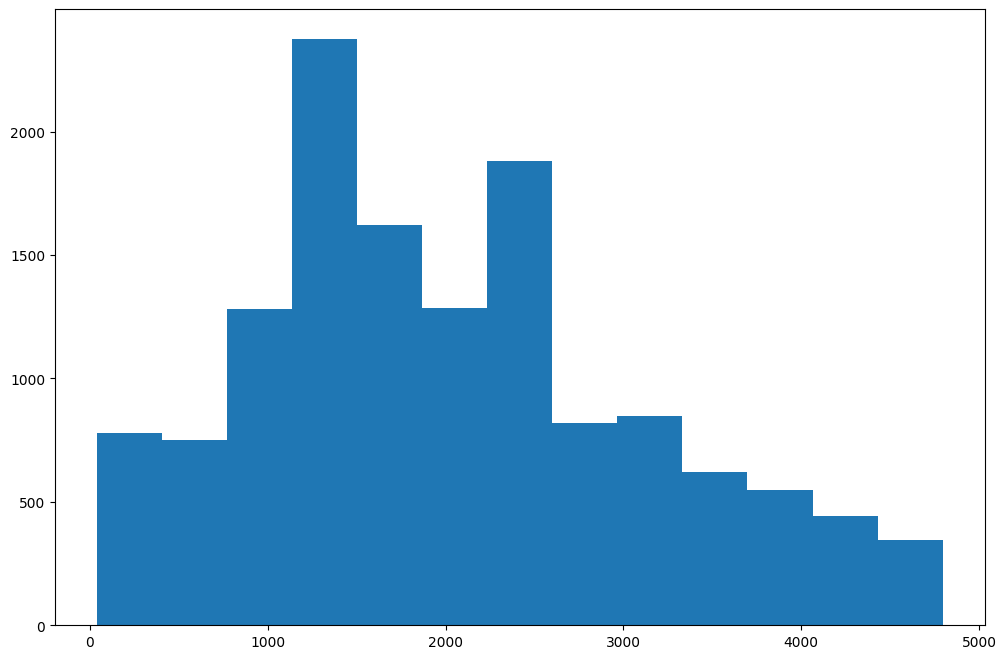

In [12]:
plt.figure(figsize=(12,8))
plt.hist(concat_df['N_Days'], bins=13);

In [13]:
view_cat_target_feature(df=concat_df, feature='N_Days', target='Status', bins=13)

,C,D,CL
cut_of_N_Days,,,
0,6.611570,92.355372,1.033058
1,16.008772,75.438596,8.552632
2,26.658323,67.459324,5.882353
3,68.690314,25.920873,5.388813
4,70.903674,25.024826,4.071500
5,81.321474,17.153748,1.524778
6,73.623446,21.758437,4.618117
7,78.678038,20.255864,1.066098
8,79.349904,19.120459,1.529637


### Drug

In [14]:
concat_df['Drug'].value_counts(dropna=False)

Drug
Placebo            6858
D-penicillamine    6630
NaN                 106
Name: count, dtype: int64

In [15]:
concat_df.fillna({'Drug': 'UNK'}, inplace=True)

In [16]:
view_cat_target_feature(df=concat_df, feature='Drug', target='Status')

,C,D,CL
cut_of_Drug,,,
D-penicillamine,61.386627,34.641007,3.972366
Placebo,63.520653,33.285303,3.194044
UNK,60.377358,33.962264,5.660377


In [17]:
concat_df['Drug'] = concat_df['Drug'].map({
    'D-penicillamine': 1,
    'Placebo': 2,
    'UNK': 0
})

### Age

In [18]:
concat_df['Age'].describe()

count    13594.000000
mean     18426.389584
std       3647.574984
min       9598.000000
25%      15612.000000
50%      18719.000000
75%      20684.000000
max      28650.000000
Name: Age, dtype: float64

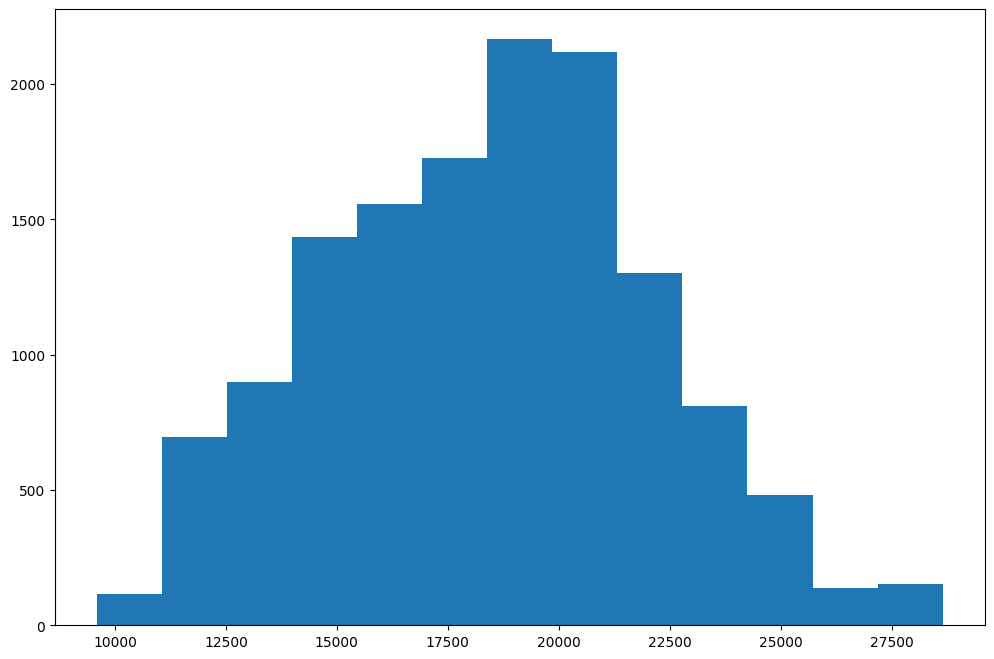

In [19]:
plt.figure(figsize=(12,8))
plt.hist(concat_df['Age'], bins=13);

In [20]:
view_cat_target_feature(concat_df, 'Age', 'Status', bins=13)

,C,D,CL
cut_of_Age,,,
0,81.481481,16.049383,2.469136
1,74.759615,17.788462,7.451923
2,68.158348,23.235800,8.605852
3,70.517052,21.342134,8.140814
4,67.035176,30.150754,2.814070
5,66.310680,28.932039,4.757282
6,52.756508,45.482389,1.761103
7,72.244570,25.985519,1.769912
8,41.237113,57.731959,1.030928


### Sex

In [21]:
concat_df['Sex'].value_counts(dropna=False)

Sex
F    12587
M     1007
Name: count, dtype: int64

In [22]:
view_cat_target_feature(concat_df, 'Sex', 'Status')

,C,D,CL
cut_of_Sex,,,
F,64.202335,32.256809,3.540856
M,40.293638,55.301794,4.404568


In [23]:
concat_df['Sex'] = concat_df['Sex'].map({'F': 0, 'M': 1})

### Stage

In [24]:
concat_df['Stage'].value_counts(dropna=False)

Stage
3.0    5430
4.0    4639
2.0    2861
1.0     658
NaN       6
Name: count, dtype: int64

In [25]:
concat_df.fillna({'Stage': 3.0}, inplace=True)

In [26]:
concat_df['Stage'] = concat_df['Stage'].astype('int8')

In [27]:
view_cat_target_feature(concat_df, 'Stage', 'Status')

,C,D,CL
cut_of_Stage,,,
1,88.516746,9.808612,1.674641
2,77.809633,19.208716,2.981651
3,72.329511,23.958962,3.711527
4,37.688795,58.166491,4.144714


### Ascites, Hepatomegaly, Spiders, Edema

In [28]:
concat_df['Ascites'].value_counts(dropna=False)

Ascites
N      12840
Y        648
NaN      106
Name: count, dtype: int64

In [29]:
concat_df['Hepatomegaly'].value_counts(dropna=False)

Hepatomegaly
Y      6932
N      6556
NaN     106
Name: count, dtype: int64

In [30]:
concat_df['Spiders'].value_counts(dropna=False)

Spiders
N      10160
Y       3328
NaN      106
Name: count, dtype: int64

In [31]:
concat_df['Edema'].value_counts(dropna=False)

Edema
N    12301
S      705
Y      588
Name: count, dtype: int64

In [32]:
imputer = SimpleImputer(strategy='most_frequent')
concat_df[['Ascites','Hepatomegaly','Spiders','Edema']] = imputer.fit_transform(concat_df[['Ascites','Hepatomegaly','Spiders','Edema']])

In [33]:
view_cat_target_feature(concat_df, 'Ascites', 'Status')

,C,D,CL
cut_of_Ascites,,,
N,65.298649,30.988761,3.712590
Y,6.435644,92.079208,1.485149


In [34]:
view_cat_target_feature(concat_df, 'Hepatomegaly', 'Status')

,C,D,CL
cut_of_Hepatomegaly,,,
N,81.743462,15.367372,2.889166
Y,44.452182,51.276695,4.271123


In [35]:
view_cat_target_feature(concat_df, 'Spiders', 'Status')

,C,D,CL
cut_of_Spiders,,,
N,71.035907,25.579917,3.384175
Y,35.781173,59.931000,4.287827


In [36]:
view_cat_target_feature(concat_df, 'Edema', 'Status')

,C,D,CL
cut_of_Edema,,,
N,67.371923,28.915502,3.712575
S,28.216704,67.494357,4.288939
Y,2.465753,96.986301,0.547945


In [37]:
for col in ['Ascites','Hepatomegaly','Spiders']:
    concat_df[col] = concat_df[col].map({'N': 0, 'Y': 1})
concat_df['Edema'] = concat_df['Edema'].map({'N': 0, 'S': 1, 'Y': 2})
concat_df[['Ascites','Hepatomegaly','Spiders','Edema']] = concat_df[['Ascites','Hepatomegaly','Spiders','Edema']].astype('int8')

### Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin

In [38]:
quanti_cols = ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

In [39]:
concat_df[quanti_cols].describe()

,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
count,13594.000000,13460.000000,13594.000000,13486.000000,13488.000000,13488.000000,13458.000000,13583.000000,13592.000000
mean,2.616033,351.715379,3.542783,84.531036,1818.429018,114.391074,115.515158,264.515424,10.633912
std,3.849061,198.211595,0.352334,76.801741,1921.938476,49.070388,52.866122,87.860881,0.794518
min,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000
25%,0.700000,248.000000,3.350000,39.000000,824.000000,75.950000,84.000000,210.000000,10.000000
50%,1.100000,299.000000,3.580000,64.000000,1166.000000,106.965000,104.000000,263.000000,10.600000
75%,3.000000,390.000000,3.770000,102.000000,1840.000000,137.950000,139.000000,316.000000,11.000000
max,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000


In [40]:
imputer = SimpleImputer()
concat_df[quanti_cols] = imputer.fit_transform(concat_df[quanti_cols])

### Interactive Features

In [41]:
concat_df.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')

We count the condition.

In [42]:
concat_df['count_condition'] = concat_df['Ascites'] + concat_df['Hepatomegaly'] + concat_df['Spiders'] + concat_df['Edema']

In [43]:
view_cat_target_feature(concat_df, 'count_condition', 'Status')

,C,D,CL
cut_of_count_condition,,,
0,85.171534,12.078253,2.750213
1,58.256228,37.402135,4.341637
2,36.819172,58.242556,4.938272
3,15.833333,79.583333,4.583333
4,4.651163,94.883721,0.465116
5,0.649351,98.701299,0.649351


`N_Days` and `Age` are both days data, so we calculate ratio of them.

In [44]:
concat_df['ratio_N_Days_Age'] = concat_df['N_Days'] / concat_df['Age'] * 100
concat_df['ratio_N_Days_Age'].describe()

count    13594.000000
mean        11.598310
std          6.823912
min          0.159087
25%          6.430002
50%         10.646879
75%         15.408918
max         45.450237
Name: ratio_N_Days_Age, dtype: float64

In [45]:
view_cat_target_feature(concat_df, 'ratio_N_Days_Age', 'Status', bins=6)

,C,D,CL
cut_of_ratio_N_Days_Age,,,
0,34.514925,61.194030,4.291045
1,74.347202,21.779053,3.873745
2,77.451593,20.112430,2.435978
3,78.070175,20.175439,1.754386
4,83.333333,14.444444,2.222222
5,90.909091,0.000000,9.090909


Now we compute ratio, sum of same dimension quanti cols.

In [46]:
concat_df['ratio_Bilirubin_Cholesterol'] = concat_df['Bilirubin'] / concat_df['Cholesterol'] * 100
concat_df['sum_Bilirubin_Cholesterol'] = concat_df['Bilirubin'] + concat_df['Cholesterol']

In [47]:
concat_df['ratio_Alk_Phos_SGOT'] = (concat_df['Alk_Phos']/1000) / concat_df['SGOT'] * 100
concat_df['sum_Alk_Phos_SGOT'] = concat_df['Alk_Phos']/1000 + concat_df['SGOT']

### Split and compute mutual info

In [48]:
input_cols = concat_df.columns.tolist()
input_cols.remove('id')
input_cols.remove('Status')

In [49]:
scaler = MinMaxScaler()
concat_df[input_cols] = scaler.fit_transform(concat_df[input_cols])

In [50]:
raw_id_max, test_id_max = raw_df['id'].max(), test_df['id'].max()

In [51]:
raw_df = concat_df[concat_df.index<=raw_id_max]
test_df = concat_df[(concat_df.index<=test_id_max)&(concat_df.index>raw_id_max)]
original_df = concat_df[concat_df.index>test_id_max]

In [52]:
for df in [raw_df, original_df]:
    df['Status'] = df['Status'].map({'C': 0, 'CL': 1, 'D': 2})

/tmp/ipykernel_17/443210789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Status'] = df['Status'].map({'C': 0, 'CL': 1, 'D': 2})
/tmp/ipykernel_17/443210789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Status'] = df['Status'].map({'C': 0, 'CL': 1, 'D': 2})


In [53]:
concat_df = pd.concat([raw_df, original_df]).copy()

In [54]:
inputs, targets = concat_df[input_cols], concat_df['Status']

In [55]:
%%time
mutual_info = mutual_info_classif(inputs, targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )

CPU times: user 917 ms, sys: 7.21 ms, total: 925 ms
Wall time: 924 ms


In [56]:
mutual_info.style.background_gradient('cool')

,Numerical_Feature_MI
ratio_Bilirubin_Cholesterol,0.208347
N_Days,0.202547
ratio_N_Days_Age,0.192957
Bilirubin,0.190424
sum_Alk_Phos_SGOT,0.188904
sum_Bilirubin_Cholesterol,0.188141
Copper,0.167107
Alk_Phos,0.154743
Cholesterol,0.150909
ratio_Alk_Phos_SGOT,0.141914


## Training model and tuning hyperparameters

In [57]:
def cross_validation(clf, cv, inputs, targets, num_classes=2,
                     test_inputs=None, need_print=False):
    train_accs = []
    val_accs = []
    if test_inputs is not None:
        test_preds = np.zeros((len(test_inputs), num_classes))
    else:
        test_preds = np.zeros((len(inputs), num_classes))
    for fold, (train_idx, val_idx) in enumerate(cv.split(inputs, targets)):
        X_train = inputs.iloc[train_idx].reset_index(drop=True)
        y_train = targets.iloc[train_idx].reset_index(drop=True)
        X_val = inputs.iloc[val_idx].reset_index(drop=True)
        y_val = targets.iloc[val_idx].reset_index(drop=True)

        clf.fit(X_train, y_train)

        train_pred = clf.predict_proba(X_train)
        train_acc = log_loss(y_train, train_pred)
        train_accs.append(train_acc)
        val_pred = clf.predict_proba(X_val)
        val_acc = log_loss(y_val, val_pred)
        val_accs.append(val_acc)

        if need_print:
            print(f'Fold {fold}: train_acc = {train_acc:.5f}, val_acc = {val_acc:.5f}')

        if test_inputs is not None:
            test_pred = clf.predict_proba(test_inputs)
            test_preds += test_pred/cv.get_n_splits()
            
    m_train_acc = np.mean(train_accs)
    s_train_acc = np.std(train_accs)
    m_val_acc = np.mean(val_accs)
    s_val_acc = np.std(val_accs)
    
    msg = f'{m_val_acc:.7f} ± {s_val_acc:.7f}'
    
    if need_print:
        print(f'Train acc: {m_train_acc:.7f} ± {s_train_acc:.7f} | Val acc: {m_val_acc:.7f} ± {s_val_acc:.7f}')
    return test_preds, msg

In [58]:
def test_with_models(models: dict, features: dict, 
                     df: pd.DataFrame, target: str, cv):
    result = dict()
    result['Classifier'] = []
    for feature, _ in features.items():
        result[f'Acc with {feature} features'] = []
    targets = df[target]
    for name, model in models.items():
        result['Classifier'].append(name)
        for f_name, feature in features.items():
            inputs = df[feature]
            _, msg = cross_validation(model, cv, 
                                         inputs, targets,
                                         num_classes=3,
                                         test_inputs=None, 
                                         need_print=False)
            result[f'Acc with {f_name} features'].append(msg)
    
    return pd.DataFrame(result)

In [59]:
classifiers = {
    'Logit': LogisticRegression(n_jobs=-1, max_iter=1000),
    'RandomForest': RandomForestClassifier(n_jobs=-1),
    'XGB': XGBClassifier(n_jobs=-1),
    'LGBM' : LGBMClassifier(n_jobs=-1,verbose=0),
    'CAT': CatBoostClassifier(logging_level='Silent')
}
features = {
    'all': input_cols
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

First we look at raw_df

In [60]:
%%time
test_with_models(classifiers, features, raw_df, 'Status', cv)

CPU times: user 2min 55s, sys: 13.5 s, total: 3min 9s
Wall time: 1min 2s


,Classifier,Acc with all features
0,Logit,0.5263956 ± 0.0116410
1,RandomForest,0.5599749 ± 0.0259000
2,XGB,0.5155798 ± 0.0165749
3,LGBM,0.4708638 ± 0.0147972
4,CAT,0.4660896 ± 0.0100640


In [61]:
%%time
test_with_models(classifiers, features, concat_df, 'Status', cv)

CPU times: user 2min 46s, sys: 13.9 s, total: 3min
Wall time: 1min 7s


,Classifier,Acc with all features
0,Logit,0.5294375 ± 0.0072297
1,RandomForest,0.5443553 ± 0.0373445
2,XGB,0.5075710 ± 0.0210886
3,LGBM,0.4599496 ± 0.0163209
4,CAT,0.4558352 ± 0.0148946


So, we choose `concat_df` and 4 model to optim is `Logit`, `RF`, `LGBM`, `CAT`.

In [62]:
inputs, targets = concat_df[input_cols], concat_df['Status']
test_inputs = test_df[input_cols]

In [63]:
scores = {
    'Classifier': [],
    'Train Score': [],
    'Val Score': [],
    'Test Score': []
}

### Logistic Regression

In [64]:
%%time
clf = LogisticRegression(max_iter=1000, n_jobs=-1)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.52746, val_acc = 0.51567
Fold 1: train_acc = 0.52352, val_acc = 0.53219
Fold 2: train_acc = 0.52288, val_acc = 0.53445
Fold 3: train_acc = 0.52239, val_acc = 0.53568
Fold 4: train_acc = 0.52408, val_acc = 0.52920
Train acc: 0.5240658 ± 0.0017889 | Val acc: 0.5294375 ± 0.0072297
CPU times: user 4.31 s, sys: 3.18 s, total: 7.49 s
Wall time: 1.89 s


In [65]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_logit.csv', index=None)

In [66]:
scores['Classifier'].append('Logit without tuning')
scores['Train Score'].append(0.52407)
scores['Val Score'].append(0.52944)
scores['Test Score'].append(0.51082)

In [67]:
param_dis = {
    'solver': ['lbfgs','newton-cg','sag','saga'],
    'penalty': ['l2',None],
    'tol': loguniform(1e-6,1e-2),
    'C': loguniform(1e-3,5),
    'max_iter': np.arange(300,1500,200),
    'n_jobs': [-1]
}

In [68]:
'''search = RandomizedSearchCV(LogisticRegression(),
                            param_dis,
                            n_iter=150,
                            scoring='neg_log_loss', cv=cv,
                            refit=True, verbose=3)
search.fit(inputs, targets)'''

"search = RandomizedSearchCV(LogisticRegression(),\n                            param_dis,\n                            n_iter=150,\n                            scoring='neg_log_loss', cv=cv,\n                            refit=True, verbose=3)\nsearch.fit(inputs, targets)"

In [69]:
%%time
best_params = {
 'C': 3.871986902028346,
 'max_iter': 300,
 'penalty': 'l2',
 'solver': 'sag',
 'tol': 1.702809162585728e-05,
 'n_jobs': -1
}

clf = LogisticRegression(**best_params)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.52686, val_acc = 0.51498
Fold 1: train_acc = 0.52289, val_acc = 0.53103
Fold 2: train_acc = 0.52212, val_acc = 0.53512
Fold 3: train_acc = 0.52146, val_acc = 0.53580
Fold 4: train_acc = 0.52315, val_acc = 0.52972
Train acc: 0.5232957 ± 0.0018792 | Val acc: 0.5293271 ± 0.0075408
CPU times: user 2.68 s, sys: 1.04 s, total: 3.72 s
Wall time: 1.89 s


In [70]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_logit_tuning.csv', index=None)

In [71]:
scores['Classifier'].append('Logit with tuning')
scores['Train Score'].append(0.52330)
scores['Val Score'].append(0.52934)
scores['Test Score'].append(0.51060)

### Random Forest

In [72]:
%%time
clf = RandomForestClassifier(n_jobs=-1)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.11241, val_acc = 0.49834
Fold 1: train_acc = 0.11098, val_acc = 0.50759
Fold 2: train_acc = 0.11151, val_acc = 0.46979
Fold 3: train_acc = 0.11086, val_acc = 0.64896
Fold 4: train_acc = 0.11091, val_acc = 0.54241
Train acc: 0.1113368 ± 0.0005866 | Val acc: 0.5334173 ± 0.0622509
CPU times: user 10.9 s, sys: 28.4 ms, total: 10.9 s
Wall time: 10.9 s


In [73]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_rf.csv', index=None)

In [74]:
scores['Classifier'].append('RF without tuning')
scores['Train Score'].append(0.11154)
scores['Val Score'].append(0.52978)
scores['Test Score'].append(0.44521)

In [75]:
param_dis = {
    'n_estimators': np.arange(50,500,50),
    'max_depth': np.arange(10,70,6),
    'min_samples_split': np.arange(2,6),
    'min_samples_leaf': np.arange(1,5),
    'max_features': ['sqrt','log2',None],
    'min_weight_fraction_leaf': loguniform(1e-6,0.4),
    'max_leaf_nodes': np.arange(20,600,45),
    'n_jobs': [-1],
    'random_state': [0,17,42,123,1212],
    'max_samples': loguniform(0.2,1)
}

In [76]:
'''search = RandomizedSearchCV(RandomForestClassifier(),
                            param_dis,
                            n_iter=150,
                            scoring='neg_log_loss', cv=cv,
                            refit=True, verbose=3)
search.fit(inputs, targets)'''

"search = RandomizedSearchCV(RandomForestClassifier(),\n                            param_dis,\n                            n_iter=150,\n                            scoring='neg_log_loss', cv=cv,\n                            refit=True, verbose=3)\nsearch.fit(inputs, targets)"

In [77]:
%%time
best_params = {
 'max_depth': 16,
 'max_features': 'log2',
 'max_leaf_nodes': 425,
 'max_samples': 0.8894972009241586,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 1.6489066668787757e-05,
 'n_estimators': 250,
 'n_jobs': -1,
 'random_state': 1212
}

clf = RandomForestClassifier(**best_params)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.25603, val_acc = 0.44496
Fold 1: train_acc = 0.25164, val_acc = 0.46547
Fold 2: train_acc = 0.25638, val_acc = 0.45022
Fold 3: train_acc = 0.25314, val_acc = 0.46485
Fold 4: train_acc = 0.25428, val_acc = 0.45592
Train acc: 0.2542937 ± 0.0017771 | Val acc: 0.4562864 ± 0.0080350
CPU times: user 22.6 s, sys: 60.2 ms, total: 22.7 s
Wall time: 22.7 s


In [78]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_rf_tuning.csv', index=None)

In [79]:
scores['Classifier'].append('RF with tuning')
scores['Train Score'].append(0.25429)
scores['Val Score'].append(0.45629)
scores['Test Score'].append(0.43820)

### LGBM

In [80]:
%%time
clf = LGBMClassifier(n_jobs=-1, verbose=-1)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.14742, val_acc = 0.44444
Fold 1: train_acc = 0.13924, val_acc = 0.48133
Fold 2: train_acc = 0.14715, val_acc = 0.44093
Fold 3: train_acc = 0.14178, val_acc = 0.47617
Fold 4: train_acc = 0.14696, val_acc = 0.45687
Train acc: 0.1445092 ± 0.0033680 | Val acc: 0.4599496 ± 0.0163209
CPU times: user 6.7 s, sys: 2.56 ms, total: 6.7 s
Wall time: 6.7 s


In [81]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm.csv', index=None)

In [82]:
scores['Classifier'].append('LGBM without tuning')
scores['Train Score'].append(0.14451)
scores['Val Score'].append(0.45995)
scores['Test Score'].append(0.42371)

In [83]:
param_dis = {
    'num_leaves': np.arange(32,200,10),
    'n_jobs': [-1],
    'reg_lambda': loguniform(1e-5,4),
    'reg_alpha': loguniform(1e-5,4),
    'n_estimators': np.arange(50,341,40),
    'learning_rate': loguniform(0.001,0.2),
    'max_depth': np.arange(12,50,4),
    'min_split_gain': loguniform(1e-8,0.1),
    'min_child_weight': loguniform(1e-4,0.1),
    'min_child_samples': np.arange(8,30,4),
    'subsample': loguniform(0.25,1),
    'colsample_bytree': loguniform(0.25,1),
    'random_state': [42],
    'verbose': [-1]
}

In [84]:
'''search = RandomizedSearchCV(LGBMClassifier(),
                            param_dis,
                            n_iter=150,
                            scoring='neg_log_loss', cv=cv,
                            refit=True, verbose=3)
search.fit(inputs, targets)'''

"search = RandomizedSearchCV(LGBMClassifier(),\n                            param_dis,\n                            n_iter=150,\n                            scoring='neg_log_loss', cv=cv,\n                            refit=True, verbose=3)\nsearch.fit(inputs, targets)"

In [85]:
%%time
best_params = {
 'colsample_bytree': 0.29486700431686197,
 'learning_rate': 0.06817642591744683,
 'max_depth': 44,
 'min_child_samples': 8,
 'min_child_weight': 0.00044059678355998813,
 'min_split_gain': 3.8039048527123264e-05,
 'n_estimators': 90,
 'n_jobs': -1,
 'num_leaves': 62,
 'random_state': 42,
 'reg_alpha': 0.0001292240294847905,
 'reg_lambda': 2.219344450381771,
 'subsample': 0.37117045008198346,
 'verbose': -1
}

clf = LGBMClassifier(**best_params)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.18101, val_acc = 0.41570
Fold 1: train_acc = 0.17625, val_acc = 0.44603
Fold 2: train_acc = 0.18243, val_acc = 0.41741
Fold 3: train_acc = 0.17741, val_acc = 0.44630
Fold 4: train_acc = 0.17918, val_acc = 0.43298
Train acc: 0.1792569 ± 0.0022613 | Val acc: 0.4316842 ± 0.0132696
CPU times: user 5.8 s, sys: 6.83 ms, total: 5.8 s
Wall time: 5.8 s


In [86]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm_tuning.csv', index=None)

In [87]:
scores['Classifier'].append('LGBM with tuning')
scores['Train Score'].append(0.17926)
scores['Val Score'].append(0.43168)
scores['Test Score'].append(0.41249)

### CatBoost

In [88]:
%%time
clf = CatBoostClassifier(logging_level='Silent')
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.16566, val_acc = 0.43779
Fold 1: train_acc = 0.16010, val_acc = 0.47442
Fold 2: train_acc = 0.16476, val_acc = 0.44289
Fold 3: train_acc = 0.16015, val_acc = 0.47188
Fold 4: train_acc = 0.16602, val_acc = 0.45220
Train acc: 0.1633361 ± 0.0026555 | Val acc: 0.4558352 ± 0.0148946
CPU times: user 2min 17s, sys: 10.4 s, total: 2min 28s
Wall time: 41.6 s


In [89]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat.csv', index=None)

In [90]:
scores['Classifier'].append('CAT without tuning')
scores['Train Score'].append(0.16334)
scores['Val Score'].append(0.45584)
scores['Test Score'].append(0.42504)

In [91]:
param_dis = {
    'iterations': np.arange(750,1800,250),
    'learning_rate': loguniform(0.005,0.15),
    'random_seed': [42],
    'l2_leaf_reg': loguniform(0.8,50),
    'bagging_temperature': loguniform(1e-4,1),
    'random_strength': np.arange(1,10),
    'depth': np.arange(6,10),
    'min_data_in_leaf': np.arange(1,4),
    'border_count': np.arange(24,296,50),
    'logging_level': ['Silent'],
    'task_type': ['GPU']
}

In [92]:
'''search = RandomizedSearchCV(CatBoostClassifier(),
                            param_dis,
                            n_iter=90,
                            scoring='neg_log_loss', cv=cv,
                            refit=True, verbose=3)
search.fit(inputs, targets)'''

"search = RandomizedSearchCV(CatBoostClassifier(),\n                            param_dis,\n                            n_iter=90,\n                            scoring='neg_log_loss', cv=cv,\n                            refit=True, verbose=3)\nsearch.fit(inputs, targets)"

In [93]:
%%time
best_params = {
 'bagging_temperature': 0.09899722103462415,
 'border_count': 274,
 'depth': 6,
 'iterations': 1750,
 'l2_leaf_reg': 3.009289961330278,
 'learning_rate': 0.02240593653645425,
 'logging_level': 'Silent',
 'min_data_in_leaf': 2,
 'random_seed': 42,
 'random_strength': 9
}

clf = CatBoostClassifier(**best_params)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.26875, val_acc = 0.42181
Fold 1: train_acc = 0.25612, val_acc = 0.45658
Fold 2: train_acc = 0.26551, val_acc = 0.43037
Fold 3: train_acc = 0.26765, val_acc = 0.44947
Fold 4: train_acc = 0.26871, val_acc = 0.43928
Train acc: 0.2653483 ± 0.0047594 | Val acc: 0.4395030 ± 0.0125488
CPU times: user 4min 5s, sys: 18.1 s, total: 4min 23s
Wall time: 1min 12s


In [94]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat_tuning.csv', index=None)

In [95]:
scores['Classifier'].append('CAT with tuning')
scores['Train Score'].append(0.26535)
scores['Val Score'].append(0.43950)
scores['Test Score'].append(0.41904)

### Stack

In [96]:
logit_best_params = {
 'C': 3.871986902028346,
 'max_iter': 300,
 'penalty': 'l2',
 'solver': 'sag',
 'tol': 1.702809162585728e-05,
 'n_jobs': -1
}
rf_best_params = {
 'max_depth': 16,
 'max_features': 'log2',
 'max_leaf_nodes': 425,
 'max_samples': 0.8894972009241586,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 1.6489066668787757e-05,
 'n_estimators': 250,
 'n_jobs': -1,
 'random_state': 1212
}
lgbm_best_params = {
 'colsample_bytree': 0.29486700431686197,
 'learning_rate': 0.06817642591744683,
 'max_depth': 44,
 'min_child_samples': 8,
 'min_child_weight': 0.00044059678355998813,
 'min_split_gain': 3.8039048527123264e-05,
 'n_estimators': 90,
 'n_jobs': -1,
 'num_leaves': 62,
 'random_state': 42,
 'reg_alpha': 0.0001292240294847905,
 'reg_lambda': 2.219344450381771,
 'subsample': 0.37117045008198346,
 'verbose': -1
}
cat_best_params = {
 'bagging_temperature': 0.09899722103462415,
 'border_count': 274,
 'depth': 6,
 'iterations': 1750,
 'l2_leaf_reg': 3.009289961330278,
 'learning_rate': 0.02240593653645425,
 'logging_level': 'Silent',
 'min_data_in_leaf': 2,
 'random_seed': 42,
 'random_strength': 9
}

In [97]:
%%time
level0 = list()
level0.append(('rf', RandomForestClassifier(**rf_best_params)))
level0.append(('lgbm', LGBMClassifier(**lgbm_best_params)))

clf = StackingClassifier(estimators=level0, cv=cv)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.19073, val_acc = 0.43024
Fold 1: train_acc = 0.18732, val_acc = 0.45334
Fold 2: train_acc = 0.19301, val_acc = 0.43689
Fold 3: train_acc = 0.18945, val_acc = 0.45119
Fold 4: train_acc = 0.19265, val_acc = 0.44623
Train acc: 0.1906309 ± 0.0021045 | Val acc: 0.4435759 ± 0.0087515
CPU times: user 2min 10s, sys: 313 ms, total: 2min 10s
Wall time: 2min 10s


In [98]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_stack_rf_lgbm.csv', index=None)

In [99]:
scores['Classifier'].append('Stack RF LGBM')
scores['Train Score'].append(0.19063)
scores['Val Score'].append(0.44358)
scores['Test Score'].append(0.42708)

In [100]:
%%time
level0 = list()
level0.append(('rf', RandomForestClassifier(**rf_best_params)))
level0.append(('cat', CatBoostClassifier(**cat_best_params)))

clf = StackingClassifier(estimators=level0, cv=cv)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.24384, val_acc = 0.43144
Fold 1: train_acc = 0.23735, val_acc = 0.45641
Fold 2: train_acc = 0.24286, val_acc = 0.44314
Fold 3: train_acc = 0.24829, val_acc = 0.45517
Fold 4: train_acc = 0.24701, val_acc = 0.44943
Train acc: 0.2438698 ± 0.0038192 | Val acc: 0.4471200 ± 0.0091458
CPU times: user 24min 55s, sys: 1min 53s, total: 26min 48s
Wall time: 8min 39s


In [101]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_stack_rf_cat.csv', index=None)

In [102]:
scores['Classifier'].append('Stack RF CAT')
scores['Train Score'].append(0.24387)
scores['Val Score'].append(0.44712)
scores['Test Score'].append(0.43042)

In [103]:
%%time
level0 = list()
level0.append(('logit', LogisticRegression(**logit_best_params)))
level0.append(('lgbm', LGBMClassifier(**lgbm_best_params)))

clf = StackingClassifier(estimators=level0, cv=cv)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.20597, val_acc = 0.42840
Fold 1: train_acc = 0.20422, val_acc = 0.45211
Fold 2: train_acc = 0.20882, val_acc = 0.43361
Fold 3: train_acc = 0.20522, val_acc = 0.45152
Fold 4: train_acc = 0.21029, val_acc = 0.44738
Train acc: 0.2069008 ± 0.0022817 | Val acc: 0.4426031 ± 0.0097499
CPU times: user 34.2 s, sys: 2.18 s, total: 36.4 s
Wall time: 32.7 s


In [104]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_stack_logit_lgbm.csv', index=None)

In [105]:
scores['Classifier'].append('Stack Logit LGBM')
scores['Train Score'].append(0.20690)
scores['Val Score'].append(0.44260)
scores['Test Score'].append(0.42872)

In [106]:
%%time
level0 = list()
level0.append(('logit', LogisticRegression(**logit_best_params)))
level0.append(('rf', RandomForestClassifier(**rf_best_params)))
level0.append(('lgbm', LGBMClassifier(**lgbm_best_params)))

clf = StackingClassifier(estimators=level0, cv=cv)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.19887, val_acc = 0.42786
Fold 1: train_acc = 0.19836, val_acc = 0.45084


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2: train_acc = 0.20091, val_acc = 0.43669
Fold 3: train_acc = 0.19901, val_acc = 0.44995


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4: train_acc = 0.20144, val_acc = 0.44528
Train acc: 0.1997175 ± 0.0012213 | Val acc: 0.4421222 ± 0.0087209
CPU times: user 2min 19s, sys: 2.44 s, total: 2min 22s
Wall time: 2min 18s


In [107]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_stack_logit_rf_lgbm.csv', index=None)

In [108]:
scores['Classifier'].append('Stack Logit RF LGBM')
scores['Train Score'].append(0.19972)
scores['Val Score'].append(0.44211)
scores['Test Score'].append(0.42693)

In [109]:
%%time
level0 = list()
level0.append(('logit', LogisticRegression(**logit_best_params)))
level0.append(('lgbm', LGBMClassifier(**lgbm_best_params)))
level0.append(('cat', CatBoostClassifier(**cat_best_params)))

clf = StackingClassifier(estimators=level0, cv=cv)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 0: train_acc = 0.21808, val_acc = 0.42761


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1: train_acc = 0.21485, val_acc = 0.45154
Fold 2: train_acc = 0.22269, val_acc = 0.43494
Fold 3: train_acc = 0.22335, val_acc = 0.45061


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4: train_acc = 0.22433, val_acc = 0.44584
Train acc: 0.2206629 ± 0.0036121 | Val acc: 0.4421088 ± 0.0093460
CPU times: user 23min 40s, sys: 1min 55s, total: 25min 35s
Wall time: 7min 25s


In [110]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_stack_logit_lgbm_cat.csv', index=None)

In [111]:
scores['Classifier'].append('Stack Logit LGBM CAT')
scores['Train Score'].append(0.22063)
scores['Val Score'].append(0.44211)
scores['Test Score'].append(0.42794)

### Voting

In [112]:
%%time
ests = list()
ests.append(('logit', LogisticRegression(**logit_best_params)))
ests.append(('rf', RandomForestClassifier(**rf_best_params)))
ests.append(('lgbm', LGBMClassifier(**lgbm_best_params)))
ests.append(('cat', CatBoostClassifier(**cat_best_params)))

weights = [0.1,0.1,0.6,0.2]

clf = VotingClassifier(ests, voting='soft', weights=weights)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.22394, val_acc = 0.41528
Fold 1: train_acc = 0.21795, val_acc = 0.44296
Fold 2: train_acc = 0.22411, val_acc = 0.42077
Fold 3: train_acc = 0.22056, val_acc = 0.44356
Fold 4: train_acc = 0.22226, val_acc = 0.43098
Train acc: 0.2217639 ± 0.0023020 | Val acc: 0.4307091 ± 0.0114191
CPU times: user 4min 35s, sys: 20.1 s, total: 4min 55s
Wall time: 1min 42s


In [113]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_vote_1_1_6_2.csv', index=None)

In [114]:
scores['Classifier'].append('Vote Logit(1) RF(1) LGBM(6) CAT(2)')
scores['Train Score'].append(0.22176)
scores['Val Score'].append(0.43071)
scores['Test Score'].append(0.41448)

In [115]:
%%time
ests = list()
ests.append(('logit', LogisticRegression(**logit_best_params)))
ests.append(('rf', RandomForestClassifier(**rf_best_params)))
ests.append(('lgbm', LGBMClassifier(**lgbm_best_params)))
ests.append(('cat', CatBoostClassifier(**cat_best_params)))

weights = [0.05,0.15,0.5,0.3]

clf = VotingClassifier(ests, voting='soft', weights=weights)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.22381, val_acc = 0.41485
Fold 1: train_acc = 0.21731, val_acc = 0.44323
Fold 2: train_acc = 0.22380, val_acc = 0.42058
Fold 3: train_acc = 0.22077, val_acc = 0.44316
Fold 4: train_acc = 0.22239, val_acc = 0.43087
Train acc: 0.2216162 ± 0.0024280 | Val acc: 0.4305386 ± 0.0115393
CPU times: user 4min 38s, sys: 20.8 s, total: 4min 59s
Wall time: 1min 43s


In [116]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_vote_05_15_5_3.csv', index=None)

In [117]:
scores['Classifier'].append('Vote Logit(0.5) RF(1.5) LGBM(5) CAT(3)')
scores['Train Score'].append(0.22162)
scores['Val Score'].append(0.43053)
scores['Test Score'].append(0.41387)

In [118]:
%%time
ests = list()
ests.append(('logit', LogisticRegression(**logit_best_params)))
ests.append(('rf', RandomForestClassifier(**rf_best_params)))
ests.append(('lgbm', LGBMClassifier(**lgbm_best_params)))
ests.append(('cat', CatBoostClassifier(**cat_best_params)))

weights = [0,0.2,0.45,0.35]

clf = VotingClassifier(ests, voting='soft', weights=weights)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.21987, val_acc = 0.41478
Fold 1: train_acc = 0.21317, val_acc = 0.44380
Fold 2: train_acc = 0.21985, val_acc = 0.42038
Fold 3: train_acc = 0.21705, val_acc = 0.44326
Fold 4: train_acc = 0.21862, val_acc = 0.43125
Train acc: 0.2177125 ± 0.0024972 | Val acc: 0.4306916 ± 0.0117448
CPU times: user 4min 38s, sys: 21 s, total: 4min 59s
Wall time: 1min 44s


In [119]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_vote_0_2_45_35.csv', index=None)

In [120]:
scores['Classifier'].append('Vote Logit(0) RF(2) LGBM(4.5) CAT(3.5)')
scores['Train Score'].append(0.21771)
scores['Val Score'].append(0.43069)
scores['Test Score'].append(0.41346)

In [121]:
%%time
ests = list()
ests.append(('logit', LogisticRegression(**logit_best_params)))
ests.append(('rf', RandomForestClassifier(**rf_best_params)))
ests.append(('lgbm', LGBMClassifier(**lgbm_best_params)))
ests.append(('cat', CatBoostClassifier(**cat_best_params)))

weights = [0,0.15,0.55,0.3]

clf = VotingClassifier(ests, voting='soft', weights=weights)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.21230, val_acc = 0.41369
Fold 1: train_acc = 0.20592, val_acc = 0.44314
Fold 2: train_acc = 0.21254, val_acc = 0.41889
Fold 3: train_acc = 0.20934, val_acc = 0.44281
Fold 4: train_acc = 0.21095, val_acc = 0.43052
Train acc: 0.2102107 ± 0.0024299 | Val acc: 0.4298080 ± 0.0120535
CPU times: user 4min 36s, sys: 20.2 s, total: 4min 56s
Wall time: 1min 43s


In [122]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_vote_0_15_55_3.csv', index=None)

In [123]:
scores['Classifier'].append('Vote Logit(0) RF(1.5) LGBM(5.5) CAT(3)')
scores['Train Score'].append(0.21021)
scores['Val Score'].append(0.42981)
scores['Test Score'].append(0.41253)

In [124]:
%%time
ests = list()
ests.append(('logit', LogisticRegression(**logit_best_params)))
ests.append(('rf', RandomForestClassifier(**rf_best_params)))
ests.append(('lgbm', LGBMClassifier(**lgbm_best_params)))
ests.append(('cat', CatBoostClassifier(**cat_best_params)))

weights = [0,0.05,0.6,0.35]

clf = VotingClassifier(ests, voting='soft', weights=weights)
test_preds, _ = cross_validation(clf, cv, inputs, targets, num_classes=3, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.20926, val_acc = 0.41253
Fold 1: train_acc = 0.20257, val_acc = 0.44350
Fold 2: train_acc = 0.20946, val_acc = 0.41807
Fold 3: train_acc = 0.20632, val_acc = 0.44273
Fold 4: train_acc = 0.20796, val_acc = 0.43025
Train acc: 0.2071150 ± 0.0025358 | Val acc: 0.4294169 ± 0.0125727
CPU times: user 4min 38s, sys: 20.3 s, total: 4min 58s
Wall time: 1min 43s


In [125]:
sub_df[['Status_C', 'Status_CL', 'Status_D']] = test_preds
sub_df.to_csv('/kaggle/working/sub_vote_0_05_6_35.csv', index=None)

In [126]:
scores['Classifier'].append('Vote Logit(0) RF(0.5) LGBM(6) CAT(3.5)')
scores['Train Score'].append(0.20712)
scores['Val Score'].append(0.42942)
scores['Test Score'].append(0.41192)

### Best

In [127]:
scores_df = pd.DataFrame(scores)
scores_df.style.background_gradient("cool")

,Classifier,Train Score,Val Score,Test Score
0,Logit without tuning,0.524070,0.529440,0.510820
1,Logit with tuning,0.523300,0.529340,0.510600
2,RF without tuning,0.111540,0.529780,0.445210
3,RF with tuning,0.254290,0.456290,0.438200
4,LGBM without tuning,0.144510,0.459950,0.423710
5,LGBM with tuning,0.179260,0.431680,0.412490
6,CAT without tuning,0.163340,0.455840,0.425040
7,CAT with tuning,0.265350,0.439500,0.419040
8,Stack RF LGBM,0.190630,0.443580,0.427080
9,Stack RF CAT,0.243870,0.447120,0.430420


In [128]:
sub_df = pd.read_csv('/kaggle/working/sub_vote_0_05_6_35.csv')
sub_df.to_csv('/kaggle/working/submission.csv')